タンデムリピート内部でどのくらいの overlap が期待されるかを調べるために、通常の領域で daligner を動かしてみる。

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.display import display
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.io as pio
pio.templates.default = 'plotly_white'
import logging
import logzero
logzero.loglevel(logging.INFO)

In [2]:
from dataclasses import dataclass
from typing import List, Tuple
from collections import Counter, defaultdict
import random
from copy import copy
import numpy as np
import pandas as pd
import igraph as ig
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from logzero import logger
import consed
from BITS.clustering.seq import ClusteringSeq
from BITS.seq.io import save_fasta
from BITS.seq.align import EdlibRunner
from BITS.seq.consed import ConsedRunner
from BITS.seq.utils import revcomp
from BITS.util.io import save_pickle, load_pickle
from BITS.util.proc import run_command, NoDaemonPool
from BITS.plot.plotly import make_line, make_hist, make_scatter, make_layout, show_plot
from vca.types import TRUnit

In [3]:
dir_fname = 'work/'
import os
os.chdir(dir_fname)

In [5]:
!(ls -l)

合計 22997856
-rw-r--r-- 1 yoshihiko_s users  708239732  9月 24 18:01 2019 DMEL_CSS.1.las
-rw-r--r-- 1 yoshihiko_s users  697492712  9月 24 18:01 2019 DMEL_CSS.10.las
-rw-r--r-- 1 yoshihiko_s users  682920424  9月 24 18:01 2019 DMEL_CSS.11.las
-rw-r--r-- 1 yoshihiko_s users  693633636  9月 24 18:01 2019 DMEL_CSS.2.las
-rw-r--r-- 1 yoshihiko_s users  684209596  9月 24 18:01 2019 DMEL_CSS.3.las
-rw-r--r-- 1 yoshihiko_s users  695434340  9月 24 18:01 2019 DMEL_CSS.4.las
-rw-r--r-- 1 yoshihiko_s users  704002672  9月 24 18:01 2019 DMEL_CSS.5.las
-rw-r--r-- 1 yoshihiko_s users  699327944  9月 24 18:01 2019 DMEL_CSS.6.las
-rw-r--r-- 1 yoshihiko_s users  708067440  9月 24 18:01 2019 DMEL_CSS.7.las
-rw-r--r-- 1 yoshihiko_s users  711324396  9月 24 18:01 2019 DMEL_CSS.8.las
-rw-r--r-- 1 yoshihiko_s users  695593712  9月 24 18:01 2019 DMEL_CSS.9.las
-rw-r--r-- 1 yoshihiko_s users 7680246484  9月 24 18:06 2019 DMEL_CSS.S.las
lrwxrwxrwx 1 yoshihiko_s users         41  9月 10 13:29 2019 DMEL_CSS.db -> ../../../da

In [6]:
!(DBstats DMEL_CSS)


Statistics for all reads in the data set

        443,931 reads        out of         443,931  (100.0%)
  5,479,592,813 base pairs   out of   5,479,592,813  (100.0%)

         12,343 average read length
            933 standard deviation

  Base composition: 0.289(A) 0.211(C) 0.211(G) 0.289(T)

  Distribution of Read Lengths (Bin size = 1,000)

        Bin:      Count  % Reads  % Bases     Average
     20,000:          1      0.0      0.0       20333
     19,000:          0      0.0      0.0       20333
     18,000:          0      0.0      0.0       20333
     17,000:          3      0.0      0.0       17998
     16,000:          1      0.0      0.0       17675
     15,000:         32      0.0      0.0       15522
     14,000:     10,149      2.3      2.6       14218
     13,000:     86,840     21.9     23.9       13488
     12,000:    196,541     66.1     68.5       12794
     11,000:    137,936     97.2     97.9       12426
     10,000:      7,558     98.9     99.3       12397
    

In [7]:
!(HPC.daligner -T16 -k25 -w5 -l3000 -h60 -e.99 -s500 DMEL_CSS | bash -v)

# Daligner jobs (21)
daligner -k25 -w5 -h60 -e0.99 -l3000 -s500 -T16 DMEL_CSS.1 DMEL_CSS.1
daligner -k25 -w5 -h60 -e0.99 -l3000 -s500 -T16 DMEL_CSS.2 DMEL_CSS.1 DMEL_CSS.2
daligner -k25 -w5 -h60 -e0.99 -l3000 -s500 -T16 DMEL_CSS.3 DMEL_CSS.1 DMEL_CSS.2 DMEL_CSS.3
daligner -k25 -w5 -h60 -e0.99 -l3000 -s500 -T16 DMEL_CSS.4 DMEL_CSS.1 DMEL_CSS.2 DMEL_CSS.3 DMEL_CSS.4
daligner -k25 -w5 -h60 -e0.99 -l3000 -s500 -T16 DMEL_CSS.5 DMEL_CSS.1 DMEL_CSS.2
daligner -k25 -w5 -h60 -e0.99 -l3000 -s500 -T16 DMEL_CSS.5 DMEL_CSS.3 DMEL_CSS.4 DMEL_CSS.5
daligner -k25 -w5 -h60 -e0.99 -l3000 -s500 -T16 DMEL_CSS.6 DMEL_CSS.1 DMEL_CSS.2 DMEL_CSS.3
daligner -k25 -w5 -h60 -e0.99 -l3000 -s500 -T16 DMEL_CSS.6 DMEL_CSS.4 DMEL_CSS.5 DMEL_CSS.6
daligner -k25 -w5 -h60 -e0.99 -l3000 -s500 -T16 DMEL_CSS.7 DMEL_CSS.1 DMEL_CSS.2 DMEL_CSS.3
daligner -k25 -w5 -h60 -e0.99 -l3000 -s500 -T16 DMEL_CSS.7 DMEL_CSS.4 DMEL_CSS.5 DMEL_CSS.6 DMEL_CSS.7
daligner -k25 -w5 -h60 -e0.99 -l3000 -s500 -T16 DMEL_CSS.8 DMEL_CSS.1 DMEL_CSS.2 

  DMEL_CSS.8: 8,027,574 all OK
LAmerge DMEL_CSS.9 DMEL_CSS.9.DMEL_CSS.@ && LAcheck -vS DMEL_CSS DMEL_CSS.9
  DMEL_CSS.9: 7,822,893 all OK
LAmerge DMEL_CSS.10 DMEL_CSS.10.DMEL_CSS.@ && LAcheck -vS DMEL_CSS DMEL_CSS.10
  DMEL_CSS.10: 7,844,369 all OK
LAmerge DMEL_CSS.11 DMEL_CSS.11.DMEL_CSS.@ && LAcheck -vS DMEL_CSS DMEL_CSS.11
  DMEL_CSS.11: 7,716,361 all OK
# Remove block .las files (optional)
rm DMEL_CSS.1.DMEL_CSS.*.las
rm DMEL_CSS.2.DMEL_CSS.*.las
rm DMEL_CSS.3.DMEL_CSS.*.las
rm DMEL_CSS.4.DMEL_CSS.*.las
rm DMEL_CSS.5.DMEL_CSS.*.las
rm DMEL_CSS.6.DMEL_CSS.*.las
rm DMEL_CSS.7.DMEL_CSS.*.las
rm DMEL_CSS.8.DMEL_CSS.*.las
rm DMEL_CSS.9.DMEL_CSS.*.las
rm DMEL_CSS.10.DMEL_CSS.*.las
rm DMEL_CSS.11.DMEL_CSS.*.las


In [9]:
!(LAcat DMEL_CSS.*.las > DMEL_CSS.las)

In [11]:
!(LAsort DMEL_CSS.las)

## Functions

In [24]:
def las_to_ovlps(db_prefix):
    ovlps = []
    for line in run_command(f"LAdump -ocdl {db_prefix}.db {db_prefix}.las").split('\n'):
        if line.startswith('P'):
            _, a_read, b_read, strand, _ = line.strip().split(' ')
            a_read, b_read = map(int, (a_read, b_read))
        elif line.startswith('L'):
            _, a_len, b_len = line.strip().split(' ')
            a_len, b_len = map(int, (a_len, b_len))
        elif line.startswith('C'):
            _, a_start, a_end, b_start, b_end = line.strip().split(' ')
            a_start, a_end, b_start, b_end = map(int, (a_start, a_end, b_start, b_end))
        elif line.startswith('D'):
            _, n_diff = line.strip().split(' ')
            n_diff = int(n_diff)
            p_diff = round(n_diff / ((a_end - a_start + b_end - b_start) / 2) * 100, 2)   # in percentage
            ovlps.append((a_read, b_read, strand, a_start, a_end, a_len, b_start, b_end, b_len, n_diff, p_diff))
    return ovlps

In [25]:
def construct_string_graph(overlaps):
    nodes, edges = set(), set()
    for overlap in overlaps:
        f_id, g_id, strand, a_start, a_end, a_len, b_start, b_end, b_len, n_diff, p_diff = overlap
        
        if strand == 'c':
            # a_read[a_start:a_end] ~~ strand(b_read[b_start:b_end]) となるようにする
            # b の座標は常に b_read を forward に見た時のもの。配列の切り出しが先。revcomp は後。
            b_start, b_end = b_len - b_end, b_len - b_start
            
        if a_start > 0:
            if strand == 'n':
                if b_end == b_len:
                    """
                         f.B               f.E
                      f  ----------------->
                      g     --------->
                          g.B        g.E
                    """
                    overlap_type = "contains"
                else:
                    """
                         f.B         f.E
                      f  ----------->
                      g         ------------->
                                g.B           g.E
                    """
                    overlap_type = "suffix-prefix"
            else:
                if b_start == 0:
                    """
                         f.B               f.E
                      f  ----------------->
                      g     <---------
                          g.E        g.B
                    """
                    overlap_type = "contains"
                else:
                    """
                         f.B         f.E
                      f  ----------->
                      g         <-------------
                                g.E           g.B
                    """
                    overlap_type = "suffix-suffix"
        else:
            if a_end == a_len:
                overlap_type = "contained"
            else:
                if strand == 'n':
                    """
                                f.B         f.E
                      f          ----------->
                      g    ----------->
                         g.B          g.E
                    """
                    if b_start == 0:
                        overlap_type = "contains"
                    else:
                        overlap_type = "prefix-suffix"
                else:
                    """
                                f.B         f.E
                      f          ----------->
                      g    <-----------
                         g.E           g.B
                    """
                    if b_end == b_len:
                        overlap_type = "contains"
                    else:
                        overlap_type = "prefix-prefix"

        if overlap_type in ["contains", "contained"]:
            continue
        elif overlap_type == "suffix-prefix":
            nodes.update(["%s:B" % g_id,
                          "%s:B" % f_id,
                          "%s:E" % f_id,
                          "%s:E" % g_id])
            edges.update([("%s:B" % g_id, "%s:B" % f_id, a_start, p_diff),
                          ("%s:E" % f_id, "%s:E" % g_id, b_len - b_end, p_diff)])
        elif overlap_type == "suffix-suffix":
            nodes.update(["%s:E" % g_id,
                          "%s:B" % f_id,
                          "%s:E" % f_id,
                          "%s:B" % g_id])
            edges.update([("%s:E" % g_id, "%s:B" % f_id, a_start, p_diff),
                          ("%s:E" % f_id, "%s:B" % g_id, b_start, p_diff)])
        elif overlap_type == "prefix-suffix":
            nodes.update(["%s:B" % f_id,
                          "%s:B" % g_id,
                          "%s:E" % g_id,
                          "%s:E" % f_id])
            edges.update([("%s:B" % f_id, "%s:B" % g_id, b_start, p_diff),
                          ("%s:E" % g_id, "%s:E" % f_id, a_len - a_end, p_diff)])
        else:   # prefix-prefix
            nodes.update(["%s:B" % f_id,
                          "%s:E" % g_id,
                          "%s:B" % g_id,
                          "%s:E" % f_id])
            edges.update([("%s:B" % f_id, "%s:E" % g_id, b_len - b_end, p_diff),
                          ("%s:B" % g_id, "%s:E" % f_id, a_len - a_end, p_diff)])

    return ig.Graph.DictList(edges=(dict(source=s, target=t, length=l, diff=p) for s, t, l, p in edges),
                             vertices=None,
                             directed=True)

def transitive_reduction(sg):
    v_mark = ["vacant" for v in sg.vs]
    e_reduce = {e.tuple: False for e in sg.es}
    FUZZ = 10   # in bp; this length is in general shorter than unit length, thus we accept no unit shifts

    for v in sg.vs:
        if v.outdegree() == 0:
            continue

        oes = sorted(sg.es.select(_source=v.index), key=lambda x: x["length"])
        longest = oes[-1]["length"] + FUZZ
        for oe in oes:
            v_mark[oe.target] = "inplay"

        for oe in oes:
            if v_mark[oe.target] == "inplay":
                ooes = sorted(sg.es.select(_source=oe.target), key=lambda x: x["length"])
                for ooe in ooes:
                    if oe["length"] + ooe["length"] <= longest and v_mark[ooe.target] == "inplay":
                        v_mark[ooe.target] = "eliminated"

        for oe in oes:
            ooes = sorted(sg.es.select(_source=oe.target), key=lambda x: x["length"])
            if len(ooes) > 1:
                shortest = ooes[0].target
                if v_mark[shortest] == "inplay":
                    v_mark[shortest] == "eliminated"
            for ooe in ooes:
                if ooe["length"] < FUZZ and v_mark[ooe.target] == "inplay":
                    v_mark[ooe.target] = "eliminated"

        for oe in oes:
            if v_mark[oe.target] == "eliminated":
                e_reduce[oe.tuple] = True   # TODO: confirm revcomp edges will be also removed in the same way
            v_mark[oe.target] = "vacant"

    # Re-construct a graph
    return ig.Graph.DictList(edges=(dict(source=e["source"],
                                         target=e["target"],
                                         length=e["length"],
                                         diff=e["diff"])
                                    for e in sg.es
                                    if not e_reduce[e.tuple]),
                             vertices=None,
                             directed=True)

In [6]:
def draw_graph(sg):
    E = [e.tuple for e in sg.es]
    N = sg.vcount()
    pos = sg.layout('kk')

    edge_trace = go.Scatter(x=[i for l in [(pos[s][0], pos[t][0], None) for s, t in E] for i in l],
                            y=[i for l in [(pos[s][1], pos[t][1], None) for s, t in E] for i in l],
                            line=dict(width=0.5, color='black'),
                            mode='lines')

    shapes = [make_line(pos[s][0] + (pos[t][0] - pos[s][0]) * 0.7,
                        pos[s][1] + (pos[t][1] - pos[s][1]) * 0.7,
                        pos[t][0],
                        pos[t][1],
                        "black",
                        4,
                        "below")
              for s, t in E]
    
    reads = [sync_reads_by_id[int(sg.vs[node]["name"].split(':')[0])] for node in range(N)]
    cover_rates = [sum([unit.end - unit.start for unit in read.units]) / read.length for read in reads]   # by 359-bp units

    node_trace = go.Scatter(x=[pos[node][0] for node in range(N)],
                            y=[pos[node][1] for node in range(N)],
                            text=[f"{sg.vs[node]['name']}<br>{round(cover_rates[node] * 100, 1)}% covered" for node in range(N)],
                            mode='markers',
                            marker=dict(
                                color=[cr for cr in cover_rates],
                                showscale=False,
                                colorscale='YlGnBu',
                                reversescale=False,
                                size=10,
                                line=dict(width=2)))

    layout = go.Layout(width=1000, height=1000,
                       xaxis=dict(showgrid=False,
                                  zeroline=True,
                                  zerolinecolor="yellow",
                                  showticklabels=True),
                       yaxis=dict(showgrid=False,
                                  zeroline=True,
                                  zerolinecolor="yellow",
                                  showticklabels=True),
                       shapes=shapes,
                       hovermode='closest',
                       margin=go.layout.Margin(l=0, r=0, b=0, t=0),
                       showlegend=False)
    fig = go.Figure(data=[edge_trace, node_trace], layout=layout)
    py.iplot(fig)
    return pos

In [26]:
all_ovlps = las_to_ovlps("DMEL_CSS")

In [16]:
all_ovlps[:100]

[(1, 5144, 'n', 7142, 12905, 12905, 0, 5766, 12619, 9, 0.16),
 (1, 15920, 'c', 0, 8063, 12905, 4413, 12486, 12486, 19, 0.24),
 (1, 26793, 'c', 2970, 12905, 12905, 0, 9949, 11539, 17, 0.17),
 (1, 31688, 'n', 3999, 12905, 12905, 0, 8923, 13211, 41, 0.46),
 (1, 37022, 'c', 0, 5480, 12905, 6295, 11778, 11778, 9, 0.16),
 (1, 55704, 'n', 6415, 12905, 12905, 0, 6502, 13578, 14, 0.22),
 (1, 61776, 'n', 0, 10177, 12905, 3335, 13508, 13508, 33, 0.32),
 (1, 86448, 'n', 0, 10571, 12905, 1401, 11977, 11977, 16, 0.15),
 (1, 113760, 'n', 5926, 12905, 12905, 0, 6985, 12096, 9, 0.13),
 (1, 126669, 'n', 0, 10637, 12905, 1981, 12611, 12611, 52, 0.49),
 (1, 136213, 'c', 0, 8217, 12905, 3566, 11810, 11810, 77, 0.94),
 (1, 138172, 'c', 4851, 12905, 12905, 0, 8060, 12666, 15, 0.19),
 (1, 141347, 'c', 1847, 12905, 12905, 0, 11027, 14025, 69, 0.62),
 (1, 153648, 'c', 0, 6967, 12905, 5957, 12928, 12928, 50, 0.72),
 (1, 158876, 'c', 0, 3688, 12905, 10443, 14105, 14105, 88, 2.39),
 (1, 159995, 'c', 1659, 12905, 1

In [93]:
# Filter overlaps by %diff and overlap length
max_diff = 2.
min_len = 3000
ovlps = list(filter(lambda ovlp: ovlp[-1] < max_diff and ovlp[4] - ovlp[3] >= min_len, all_ovlps))

In [18]:
ovlps[:100]

[(1, 5144, 'n', 7142, 12905, 12905, 0, 5766, 12619, 9, 0.16),
 (1, 15920, 'c', 0, 8063, 12905, 4413, 12486, 12486, 19, 0.24),
 (1, 26793, 'c', 2970, 12905, 12905, 0, 9949, 11539, 17, 0.17),
 (1, 31688, 'n', 3999, 12905, 12905, 0, 8923, 13211, 41, 0.46),
 (1, 37022, 'c', 0, 5480, 12905, 6295, 11778, 11778, 9, 0.16),
 (1, 55704, 'n', 6415, 12905, 12905, 0, 6502, 13578, 14, 0.22),
 (1, 61776, 'n', 0, 10177, 12905, 3335, 13508, 13508, 33, 0.32),
 (1, 86448, 'n', 0, 10571, 12905, 1401, 11977, 11977, 16, 0.15),
 (1, 113760, 'n', 5926, 12905, 12905, 0, 6985, 12096, 9, 0.13),
 (1, 126669, 'n', 0, 10637, 12905, 1981, 12611, 12611, 52, 0.49),
 (1, 136213, 'c', 0, 8217, 12905, 3566, 11810, 11810, 77, 0.94),
 (1, 138172, 'c', 4851, 12905, 12905, 0, 8060, 12666, 15, 0.19),
 (1, 141347, 'c', 1847, 12905, 12905, 0, 11027, 14025, 69, 0.62),
 (1, 153648, 'c', 0, 6967, 12905, 5957, 12928, 12928, 50, 0.72),
 (1, 159995, 'c', 1659, 12905, 12905, 0, 11248, 12618, 27, 0.24),
 (1, 164080, 'n', 5829, 12905, 1

In [94]:
# 各リードの overlap の数
n_ovlps = Counter()   # {read_id: ovlp_count}
for ovlp in ovlps:
    n_ovlps[ovlp[0]] += 1
    n_ovlps[ovlp[1]] += 1

In [20]:
!(DBstats DMEL_CSS)


Statistics for all reads in the data set

        443,931 reads        out of         443,931  (100.0%)
  5,479,592,813 base pairs   out of   5,479,592,813  (100.0%)

         12,343 average read length
            933 standard deviation

  Base composition: 0.289(A) 0.211(C) 0.211(G) 0.289(T)

  Distribution of Read Lengths (Bin size = 1,000)

        Bin:      Count  % Reads  % Bases     Average
     20,000:          1      0.0      0.0       20333
     19,000:          0      0.0      0.0       20333
     18,000:          0      0.0      0.0       20333
     17,000:          3      0.0      0.0       17998
     16,000:          1      0.0      0.0       17675
     15,000:         32      0.0      0.0       15522
     14,000:     10,149      2.3      2.6       14218
     13,000:     86,840     21.9     23.9       13488
     12,000:    196,541     66.1     68.5       12794
     11,000:    137,936     97.2     97.9       12426
     10,000:      7,558     98.9     99.3       12397
    

In [95]:
n_ovlps_for_each_read = [n_ovlps[read_id] // 2 for read_id in range(1, 443931 + 1)]

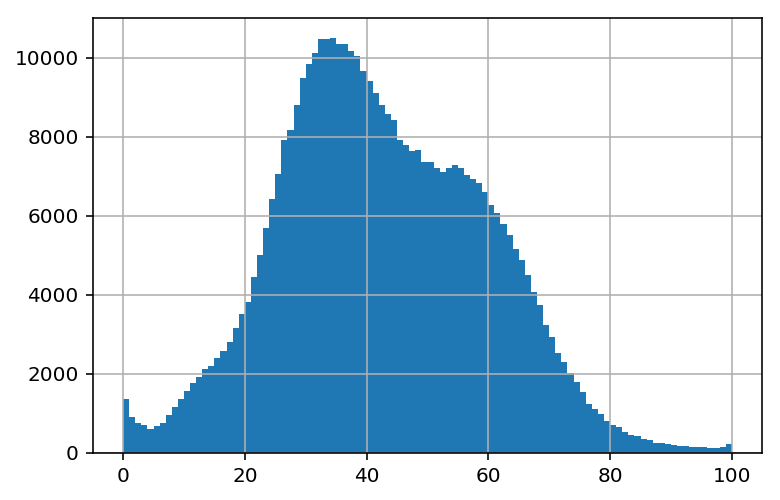

In [96]:
pd.Series(n_ovlps_for_each_read).hist(bins=100, range=(0, 100))

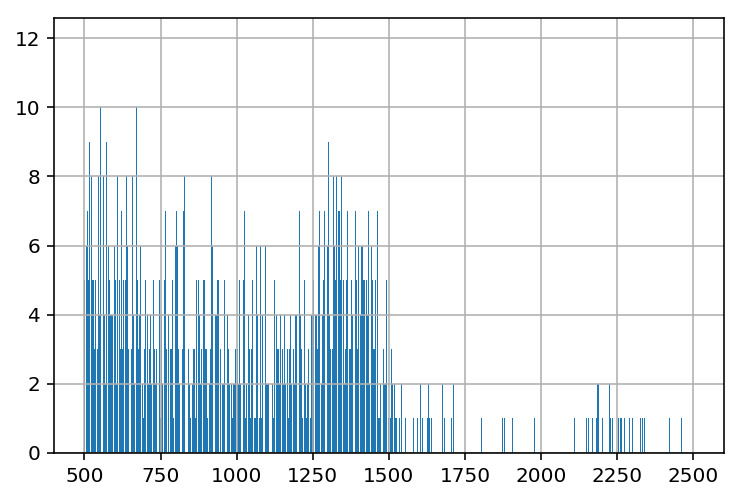

In [17]:
pd.Series(n_ovlps_for_each_read).hist(bins=2500, range=(500, 2500))

<100 occurrence k-mer しかないのに 2500 overlaps もあることがある。

In [97]:
read_n_ovlps = {read_id: n_ovlps[read_id] // 2 for read_id in range(1, 443931 + 1)}

In [12]:
[read.id for read in centromere_reads]

[73,
 123,
 236,
 300,
 369,
 395,
 546,
 559,
 644,
 697,
 738,
 741,
 762,
 765,
 797,
 862,
 875,
 951,
 1005,
 1164,
 1671,
 1803,
 2226,
 2291,
 2784,
 3033,
 3100,
 3120,
 3196,
 3309,
 3571,
 3608,
 3696,
 3851,
 3984,
 4062,
 4134,
 4194,
 4259,
 4306,
 4330,
 4443,
 4636,
 4883,
 4886,
 5113,
 5208,
 5251,
 5298,
 5299,
 5431,
 5521,
 5607,
 5713,
 5936,
 6059,
 6290,
 6428,
 6755,
 6767,
 6796,
 6867,
 7199,
 7333,
 7373,
 7418,
 7454,
 7539,
 7556,
 7564,
 7572,
 7708,
 7723,
 7726,
 7758,
 7898,
 8077,
 8208,
 8263,
 8339,
 8366,
 8600,
 8670,
 8868,
 8875,
 8877,
 8918,
 8962,
 9046,
 9086,
 9143,
 9352,
 9361,
 9396,
 9655,
 9721,
 9731,
 9760,
 9800,
 9973,
 9998,
 10305,
 10423,
 10643,
 10757,
 10811,
 10827,
 10846,
 11160,
 11236,
 11418,
 11448,
 11472,
 11630,
 11811,
 11840,
 11920,
 11947,
 11970,
 12240,
 12281,
 12897,
 12995,
 13406,
 13541,
 13702,
 13712,
 14003,
 14352,
 14493,
 14547,
 14647,
 14679,
 14819,
 14842,
 14887,
 14889,
 14910,
 14935,
 15184,


In [4]:
db_prefix = "DMEL_CSS"
db_fname = f"{db_prefix}.db"
las_fname = f"TAN.{db_prefix}.las"

gepard_root = "/work2/yoshihiko_s/software/gepard"
gepard_jar = f"{gepard_root}/dist/Gepard-1.40.jar"
gepard_mat = f"{gepard_root}/resources/matrices/edna.mat"
gepard = f"java -cp {gepard_jar} org.gepard.client.cmdline.CommandLine -matrix {gepard_mat}"

from vca import ReadViewer
v = ReadViewer(db_fname, las_fname, gepard)

In [8]:
centromere_reads = load_pickle("centromere_reads_sync.pkl")

In [9]:
centromere_reads_by_id = {read.id: read for read in centromere_reads}

In [98]:
list(filter(lambda x: x[1] > 1000, list(read_n_ovlps.items())))

[(160, 1482),
 (424, 1495),
 (534, 1526),
 (586, 1916),
 (1062, 1447),
 (1417, 1456),
 (1419, 2282),
 (1506, 1538),
 (1568, 1370),
 (1689, 1573),
 (1693, 1313),
 (1767, 1476),
 (1896, 1421),
 (1944, 1999),
 (1993, 1574),
 (2040, 1270),
 (2050, 1613),
 (2106, 1756),
 (2324, 1271),
 (2429, 1417),
 (2442, 1584),
 (2447, 1422),
 (2774, 1080),
 (3372, 1488),
 (3427, 1463),
 (3569, 1510),
 (3623, 1504),
 (3729, 1504),
 (3754, 1453),
 (4006, 1029),
 (4164, 1259),
 (4209, 1511),
 (4328, 2938),
 (4392, 1489),
 (4423, 1037),
 (4584, 1672),
 (4731, 1455),
 (5338, 1008),
 (5533, 2170),
 (5565, 1054),
 (5738, 2534),
 (5942, 1984),
 (6238, 1414),
 (6251, 1001),
 (6278, 1208),
 (6279, 2029),
 (6360, 1123),
 (6595, 1019),
 (6627, 1519),
 (6856, 1538),
 (7035, 1497),
 (7151, 1551),
 (7720, 2610),
 (7937, 1487),
 (7964, 2075),
 (7965, 1511),
 (8198, 2617),
 (8227, 3443),
 (8302, 1468),
 (8314, 1159),
 (8366, 1936),
 (8729, 1498),
 (8817, 1231),
 (8893, 1402),
 (8950, 2061),
 (9191, 1156),
 (9204, 1519),

In [99]:
list(filter(lambda x: x[1] == 0, list(read_n_ovlps.items())))

[(174, 0),
 (738, 0),
 (799, 0),
 (2196, 0),
 (2201, 0),
 (2518, 0),
 (2939, 0),
 (3003, 0),
 (3304, 0),
 (3693, 0),
 (4062, 0),
 (4615, 0),
 (5053, 0),
 (5105, 0),
 (5299, 0),
 (5415, 0),
 (5694, 0),
 (5830, 0),
 (5970, 0),
 (6122, 0),
 (6290, 0),
 (6366, 0),
 (6400, 0),
 (6523, 0),
 (6922, 0),
 (7556, 0),
 (7723, 0),
 (7752, 0),
 (8262, 0),
 (8388, 0),
 (8531, 0),
 (8575, 0),
 (9352, 0),
 (9684, 0),
 (9871, 0),
 (10454, 0),
 (10467, 0),
 (10506, 0),
 (10573, 0),
 (10608, 0),
 (10682, 0),
 (10693, 0),
 (11005, 0),
 (11078, 0),
 (11399, 0),
 (11588, 0),
 (11616, 0),
 (11689, 0),
 (11807, 0),
 (12240, 0),
 (12279, 0),
 (12566, 0),
 (12750, 0),
 (13195, 0),
 (13509, 0),
 (13597, 0),
 (13969, 0),
 (14062, 0),
 (14238, 0),
 (14526, 0),
 (14724, 0),
 (14820, 0),
 (14954, 0),
 (15844, 0),
 (16042, 0),
 (16783, 0),
 (17309, 0),
 (17775, 0),
 (17847, 0),
 (18089, 0),
 (18172, 0),
 (18177, 0),
 (18288, 0),
 (18349, 0),
 (18683, 0),
 (18741, 0),
 (18790, 0),
 (18910, 0),
 (18952, 0),
 (19056, 0)

In [135]:
v.show(6366, dot_plot=True)

ValueError: invalid literal for int() with base 10: ''

In [124]:
!(DBshow DMEL_CSS 4615 > hoge.fasta)

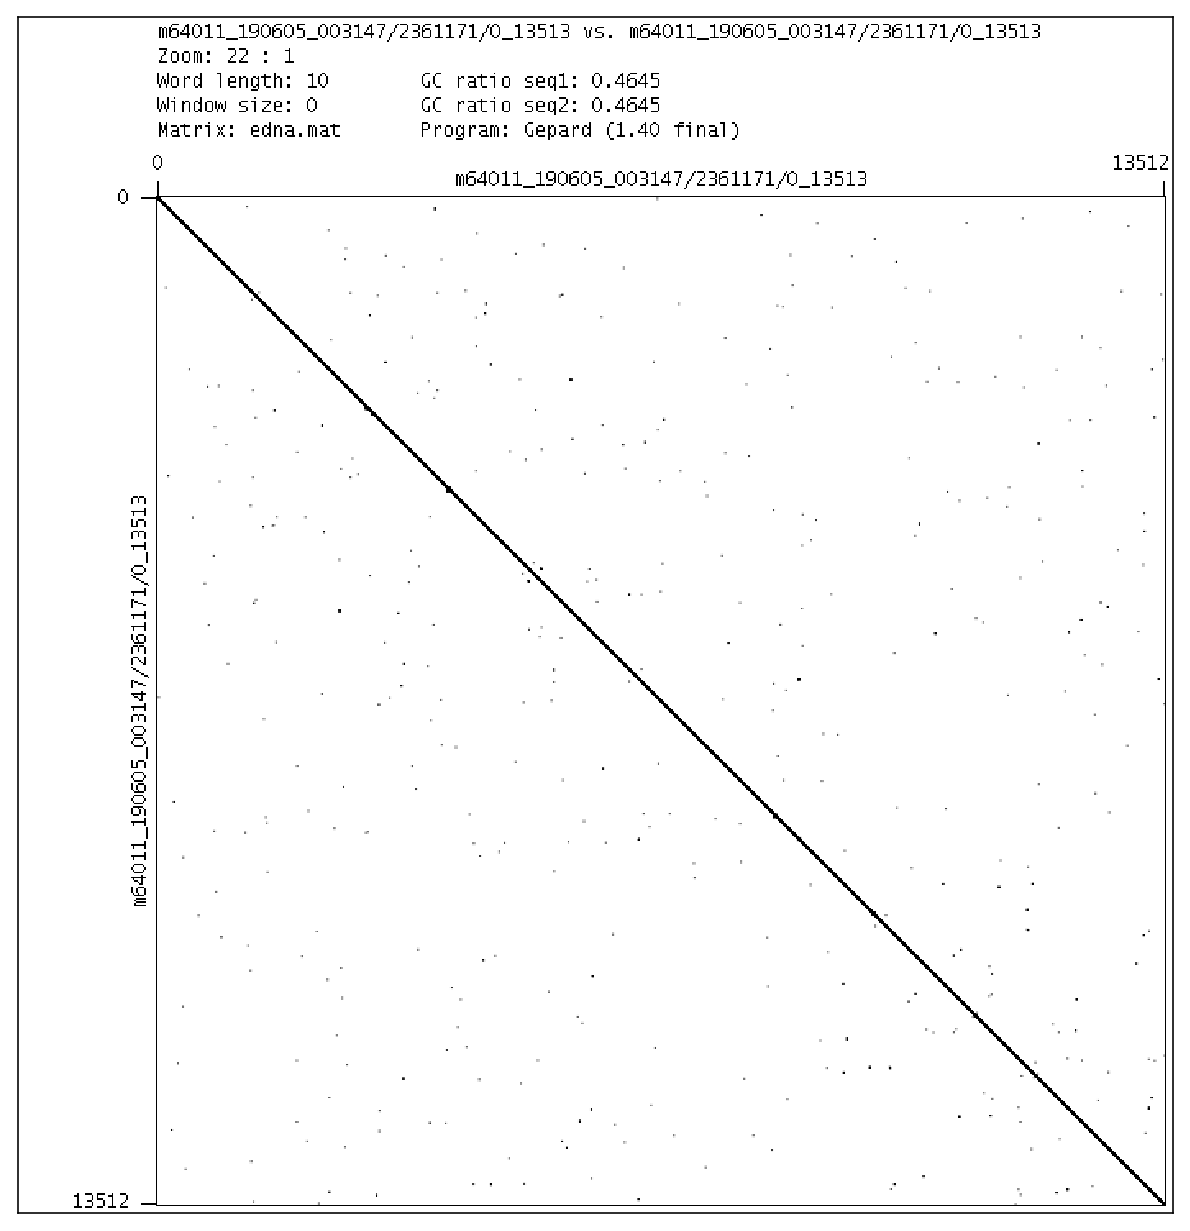

In [125]:
dp.plot_fasta("hoge.fasta", "hoge.fasta")

In [71]:
from BITS.seq.plot import DotPlot

In [72]:
dp = DotPlot(gepard)

In [110]:
!(DBshow DMEL_CSS 2518)

>m64011_190605_003147/1313184/0_12854
gttattctatgttattcaactttattctatgttattctatgttattctatgttattcaatgttattctatgttattctat
gttagtctatgtcattctatgttattctatgttattctatgttattctatgttattatatgttattctatgtttttctat
gttatccaatgttattcaatgttattcaatgttattcaatgttattcaatgttattcaatgttatccaatgttattctat
tattctttgttattctatgcttttctatgttattctatgttactctatgttattctacgttattctatgttattctatgt
tattcaatgttattctatgttattctatgttattctatgttattctatgttattctatattattctatgttattctatgt
tattctatgttattctatgttattctatgttattctatgttattctatgtattctatgttattctatgttattctatgtt
attctatgttattctatgttattctatgttattctatgttattctatgttattctatgttattctatgttattctatgtt
attctatgttattctatgttattctatgttattctatgttattctatgttattctatgttattctatgttattctatgtt
attctatgttattctatgttattctatgttattctatgttattctatgttattctatgttattctatgttattctatgtt
attctatgttattctatgttattctatgttattatatgttattatatgttattctatgttattgtatgttattcaatgtt
attctatgttattcaatgtttttctatgttattctatgttattctatgttattctatgttattctatgttattctatgtt
attctatgttattctttgttattctatgcttttctatgttatgctattttattctatgttattctatttta

## Conclusion

~1% のリードは 0 overlaps、おそらくリピート領域かノイズか。しかし 30 overlaps にピークはあるのでmax_diff=1%, min_ovlp_len=3000 というパラメタ自体は悪くないはず。

-> おそらく centromeric read filtering の時点で候補を削ぎ落としてしまっている？